In [1]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np

In [2]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from sklearn.feature_extraction import image

In [3]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

In [4]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [5]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.12033466252123938


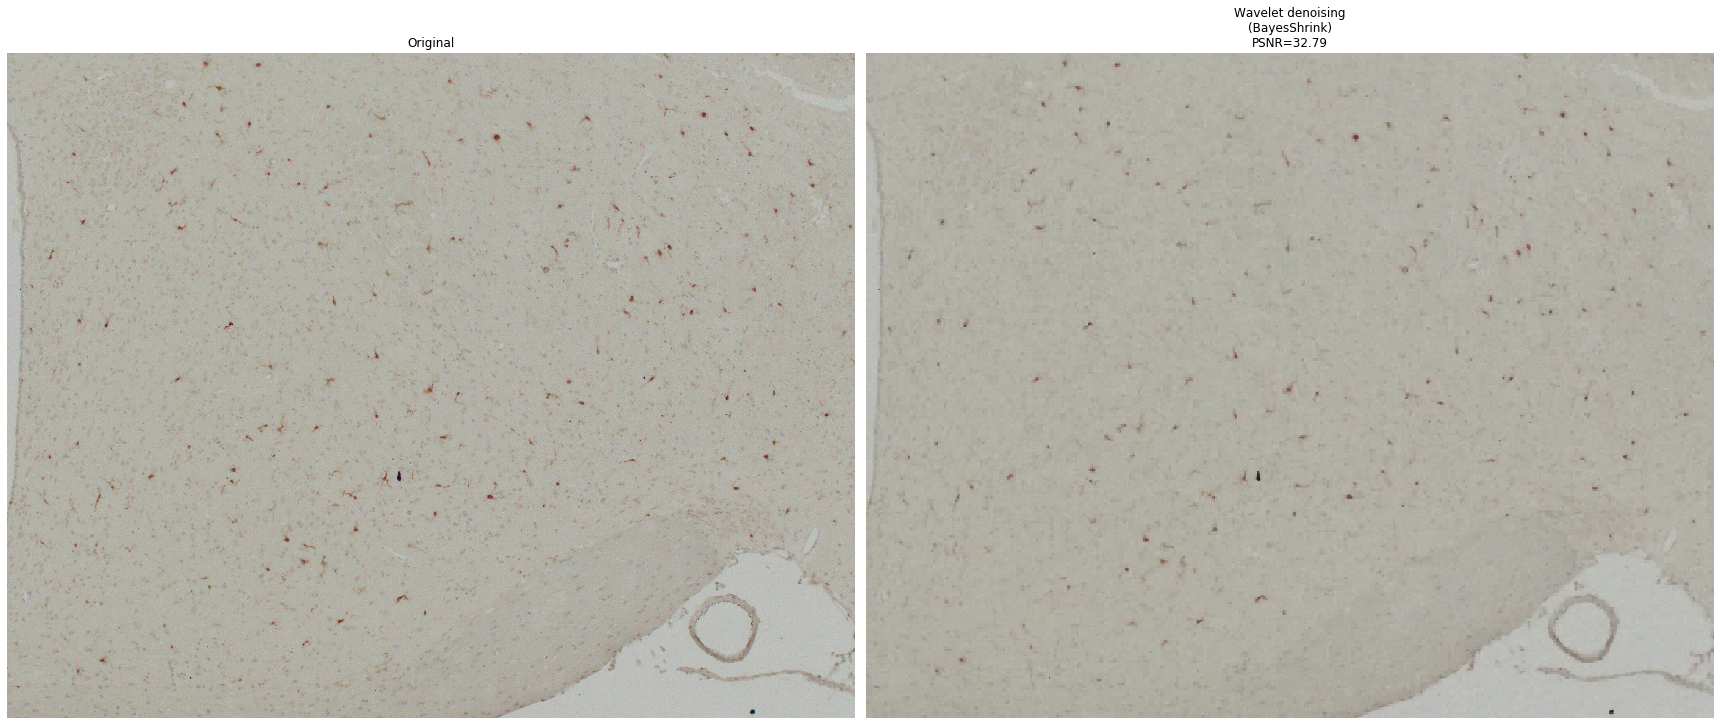

In [6]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

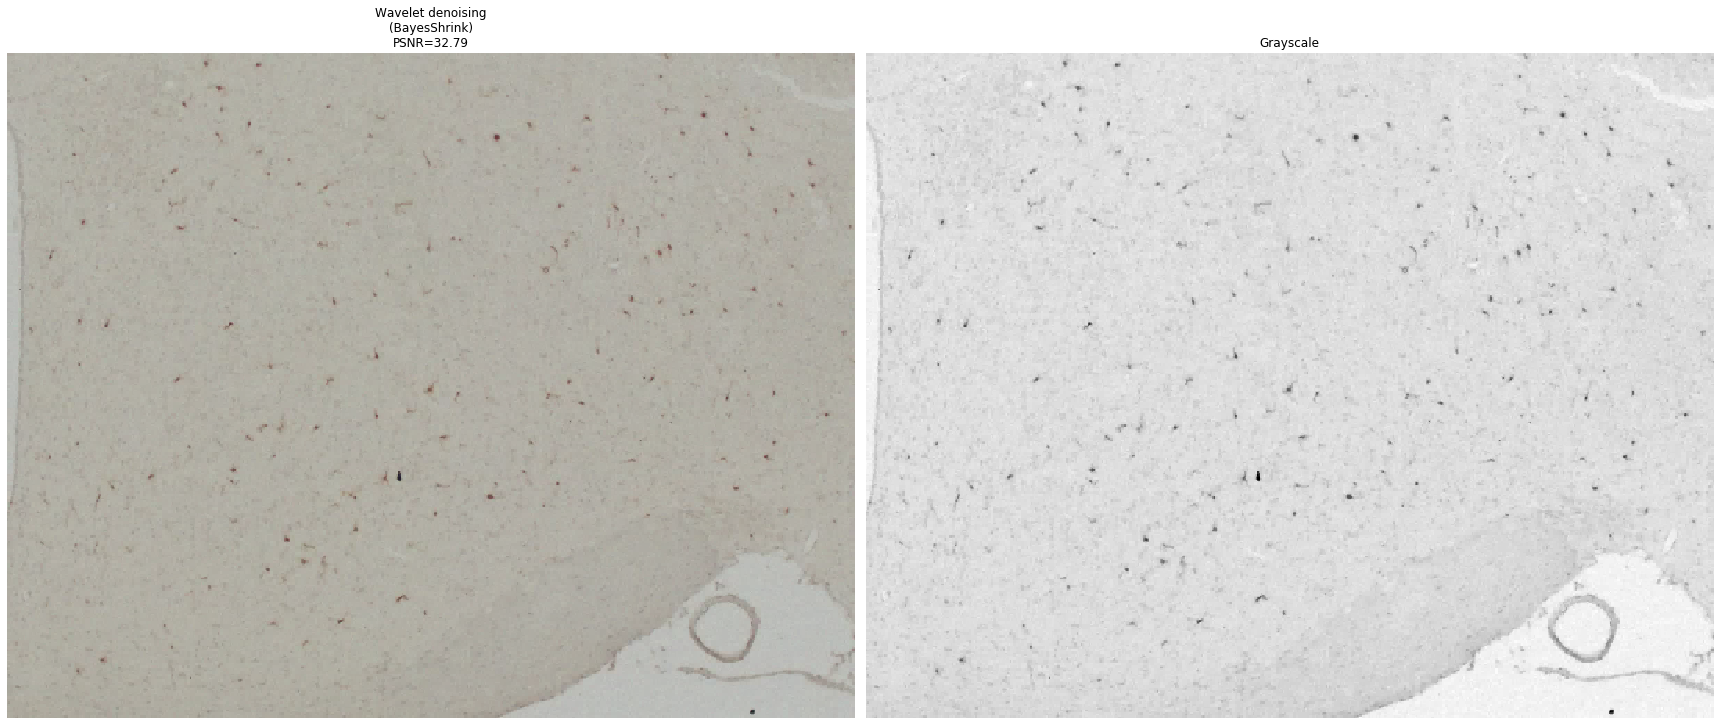

In [7]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

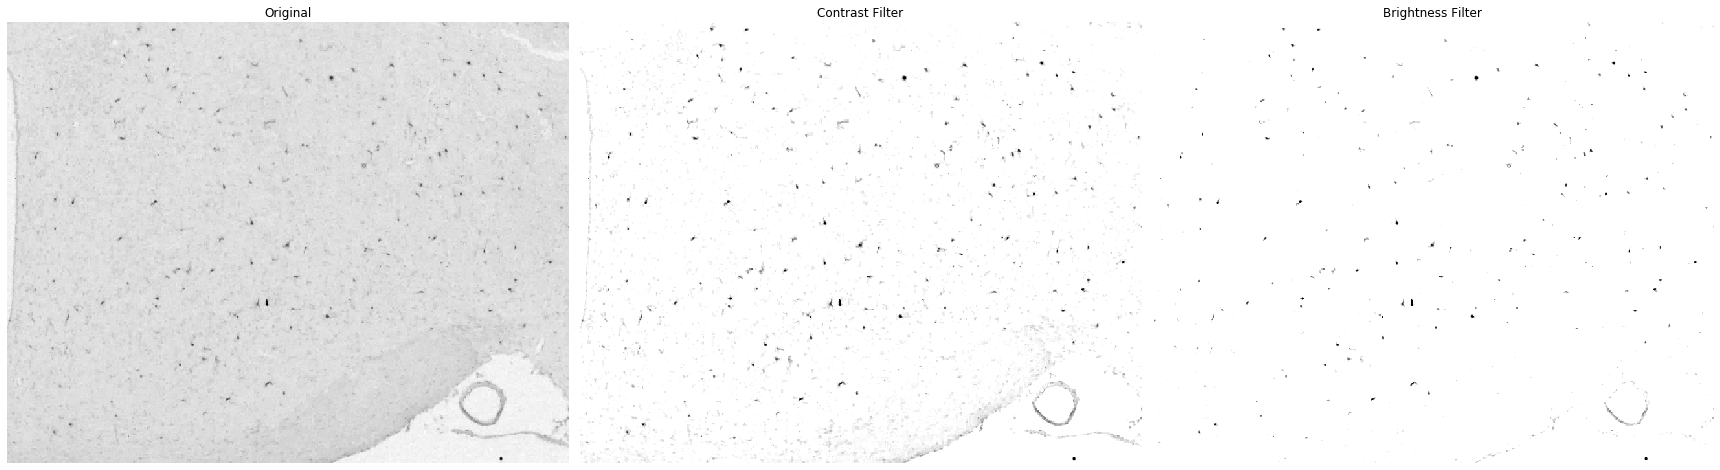

In [8]:
from PIL import Image, ImageEnhance
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [9]:
bright_bayes = np.array(bright_bayes_pil)

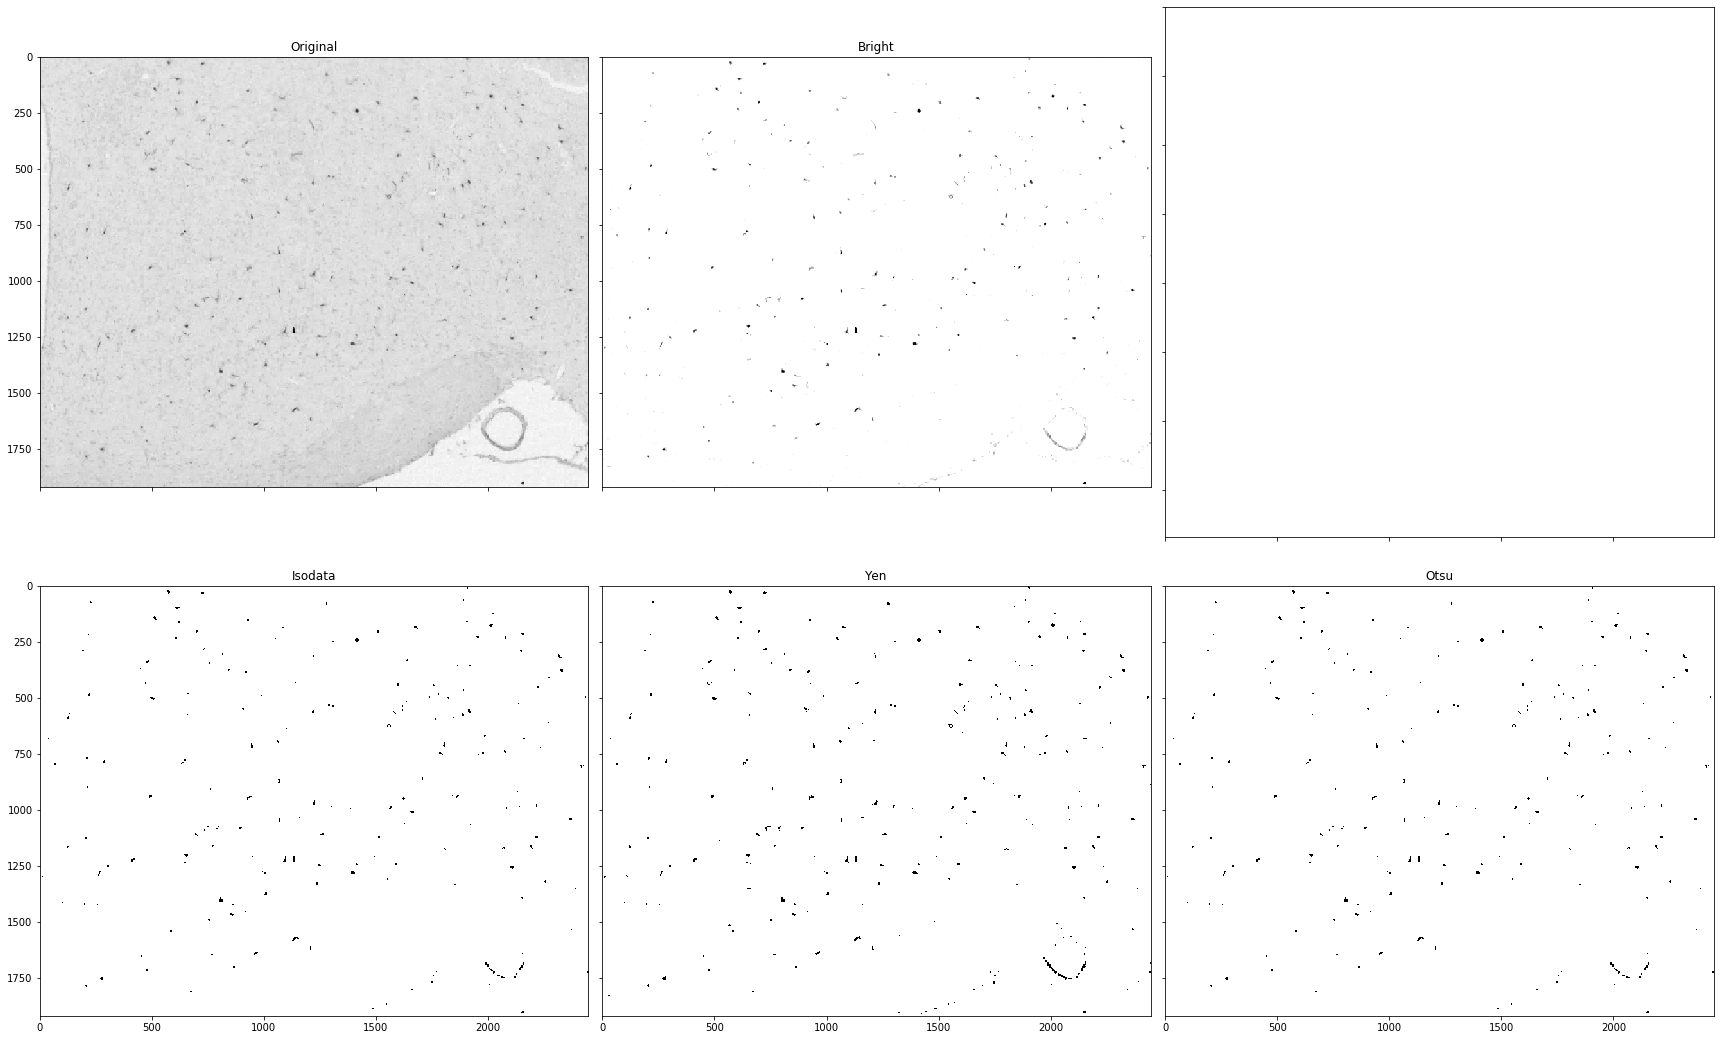

In [10]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [11]:
#use threshold to reduce number of patches to be scanned (remove empty ones)

In [12]:
def extract_patches(image, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):
    """
    Given an image, extract patches of a given shape with a certain
    amount of allowed overlap between patches, using a heuristic to
    ensure maximum coverage.
    If cropvalue is specified, it is treated as a flag denoting a pixel
    that has been cropped. Patch will be rejected if it has more than
    crop_fraction_allowed * prod(patchshape) pixels equal to cropvalue.
    Likewise, patches will be rejected for having more overlap_allowed
    fraction of their pixels contained in a patch already selected.
    """
    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict ourselves to the rectangle containing non-cropped pixels
    if cropvalue is not None:
        rows, cols = np.where(image != cropvalue)
        rows.sort(); cols.sort()
        active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    else:
        active = image

    rowstart = 0; colstart = 0

    # Array tracking where we've already taken patches.
    covered = np.zeros(active.shape, dtype=bool)
    patches = []

    while rowstart < active.shape[0] - patchshape[0]:
        # Record whether or not e've found a patch in this row, 
        # so we know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches.append(patch)
                
                # Mask the area.
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension (so that patch pixels stay contiguous in memory, in a 
    # C-ordered array).
    return np.concatenate([pat[np.newaxis, ...] for pat in patches], axis=0)

def plot_patches(patches, fignum=None, low=0, high=0):
    """
    Given a stack of 2D patches indexed by the first dimension, plot the
    patches in subplots. 
    'low' and 'high' are optional arguments to control which patches
    actually get plotted. 'fignum' chooses the figure to plot in.
    """
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in xrange(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            ax = plt.axis('off')
            im = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
            cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)

def filter_patches(patches, min_mean=0.0, min_std=0.0):
    """
    Filter patches by some criterion on their mean and variance.
    
    Takes patches, a 3-dimensional stack of image patches (where
    the first dimension indexes the patch), and a minimum
    mean and standard deviation. Returns a stack of all the 
    patches that satisfy both of these criteria.
    """
    patchdim = np.prod(patches.shape[1:])
    patchvectors = patches.reshape(patches.shape[0], patchdim)
    means = patchvectors.mean(axis=1)
    stdevs = patchvectors.std(axis=1)
    indices = (means > min_mean) & (stdevs > min_std)
    return patches[indices]

def extract_patches_from_dir(directory, patchsize, overlap_allowed=0.5,
                             cropvalue=None, crop_fraction_allowed=0.1,
                             min_mean=0, min_std=0):
    """
    Extract patches from an entire directory of images.
    `patchsize`, `overlap_allowed`, `cropvalue` and `crop_fraction_allowed`
    are passed along to `extract_patches()`. `min_mean` and `min_std` are
    passed along to `filter_patches()`.
    """
    output = {}
    for fname in os.listdir(directory):
        if fname[-4:] == '.png':
            outname = fname.replace('.','_').replace('-','_')
            assert outname not in output
            image = plt.imread(os.path.join(directory, fname))
            # Extract patches from the image.
            output[outname] = extract_patches(image, patchsize,
                                              overlap_allowed,
                                              cropvalue, crop_fraction_allowed)

            # Filter the patches that don't meet our standards.
            output[outname] = filter_patches(output[outname], min_std=min_std,
                                             min_mean=min_mean)
    return output

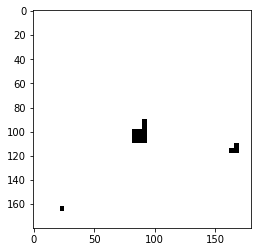

In [32]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

new = crop_center(isodata, 180, 180)
plt.imshow(new)

In [19]:
from skimage.util.shape import view_as_blocks
patches = view_as_blocks(new, block_shape=(18, 18))


In [ ]:
print('Image shape: {}'.format(isodata.shape))
patch_size = (18, 18)
#change to non-overlapping
patches = extract_patches(new, patch_size, overlap_allowed=0)
print('Patches shape: {}'.format(patches.shape))

Image shape: (1920, 2448)


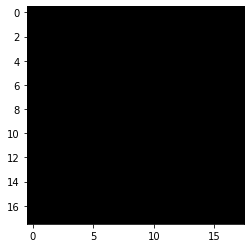

In [31]:
plt.imshow(patches[2,3])

TypeError: Invalid shape (10, 18, 18) for image data

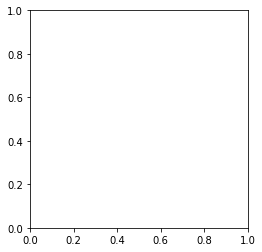

In [21]:
plt.imshow(patches[8], cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

In [ ]:
#extract shape features: solidity, orientation, diameter, area, eccentricity, convex area, major axis length, minor axis length, and extent

In [ ]:
#extract MR8 texture features: 36 bar and edge filters, a Gaussian filter, and a Laplacian of Gaussian filter. The eight highest responses are extracted to maintain rotation invariance. 

In [ ]:
#extract HoG feature

In [ ]:
feature_names = ['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent', 'hog']
#include texture features
labels = [0, 1]

In [ ]:
#features are numeric values, the vector created by combining/concatenating these values is the X data
#this vector is created for each patch, and paired with a label to create the dataset

In [ ]:
clf = svm.LinearSVC()

#clf.fit(X_train, y_train)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [ ]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches